
#<font color='Bisque'>**Enhancing Emotion Classification in Speech Using Spectrogram-Based Image Classification**</font>


<font color='CornflowerBlue'>***Introduction***</font>

Emotion recognition in speech is a challenging yet critical task in various applications, including human-computer interaction, customer service, and mental health monitoring. Traditional approaches to this problem typically involve extracting features directly from the audio signal and using these features to train classification models.









<font color='CornflowerBlue'>***Motivation***</font>

Recent advancements in image classification using deep learning models, such as convolutional neural networks (CNNs), have shown remarkable success in various domains. Given the complex nature of emotional cues in speech, we propose to leverage these advancements by converting audio recordings into spectrograms—visual representations of the audio signal—and applying image classification techniques to enhance the accuracy of emotion recognition.



<font color='CornflowerBlue'>***The primary objectives of this project are:***</font>

To explore the feasibility of using spectrograms for emotion classification in speech.

To compare the performance of traditional audio-based classifiers with spectrogram-based image classifiers.

To identify potential improvements in emotion classification accuracy using this novel approach.




<font color='CornflowerBlue'>***Problem Statement***</font>

Emotion recognition from speech involves detecting and classifying human emotions based on vocal expressions. Traditional methods often struggle with the variability and complexity of speech signals, which can be influenced by factors such as background noise, speaker differences, and recording conditions. We hypothesize that transforming these audio signals into spectrograms and applying image classification models can capture intricate patterns more effectively, thereby improving classification performance.


<font color='CornflowerBlue'>***Literature Review***</font>

Existing methods for emotion recognition in speech include various feature extraction techniques such as prosody, spectral, and voice quality features, along with machine learning algorithms like support vector machines (SVM), hidden Markov models (HMM), and random forests. While these methods have their strengths, such as capturing emotional tone and providing detailed speech signal information, they also have limitations, including sensitivity to noise and high computational requirements. Deep learning approaches, such as recurrent neural networks (RNNs) and convolutional neural networks (CNNs), have also been explored, offering advantages in capturing temporal dependencies and learning hierarchical features. However, they require substantial computational resources and large datasets.

Recent advancements in image classification using CNNs, including architectures like VGGNet, ResNet, and Inception, have significantly improved classification accuracy through deeper and more complex models. Transfer learning has further enhanced performance by utilizing pre-trained models on large image datasets. Spectrograms, which visually represent the frequency spectrum of audio signals over time, provide a promising approach by converting audio classification into an image classification task. Studies have shown the effectiveness of CNNs in processing spectrograms for tasks such as speech recognition and music genre classification.

mount of the drive - so we could work on the dataset stored on google-drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

The list of the dataset composed of 91 different speakers, 7442 recording in total

In [ ]:
import os

# List files in the specified directory
#******************************************************
#crema is the mother folder with the original data before editing

#data_path = '/content/drive/MyDrive/emotional_speech/archive/Crema'
#print(os.listdir(data_path))

***Structured CSV Creation for Balanced Dataset Splits***

Creating a CSV file with columns for speaker ID, class, type (test/validation/train), and file name ensures organized and structured data management. By randomly separating the data into 70% train, 15% validation, and 15% test sets, we ensure balanced dataset splits. Assigning each speaker to only one data type prevents overlapping, which is crucial for maintaining the integrity of the model evaluation. This approach ensures that the model is trained, validated, and tested on distinct and non-overlapping subsets of data, thereby improving the reliability and validity of the results.

In [ ]:
import os
import csv
import random

# Path to the directory containing all recordings after editing and trimming:
data_path = "/content/drive/MyDrive/emotional_speech/output_spectog"

# Initialize lists to store file paths and corresponding metadata
file_metadata = []

# Traverse through the directory and collect file paths and metadata
for filename in os.listdir(data_path):
    if filename.endswith(".wav"):
        file_path = os.path.join(data_path, filename)
        speaker_id = filename.split('_')[1]  # Extract speaker ID
        file_class = filename.split('_')[3]  # Extract class
        file_metadata.append((filename, speaker_id, file_class))

# Shuffle the metadata to ensure randomness
random.shuffle(file_metadata)

# Get unique speaker IDs
unique_speaker_ids = list(set([speaker_id for _, speaker_id, _ in file_metadata]))

# Calculate the number of speaker IDs for each set
total_speaker_ids = len(unique_speaker_ids)
train_speaker_ids = int(0.7 * total_speaker_ids)
validation_speaker_ids = test_speaker_ids = (total_speaker_ids - train_speaker_ids) // 2

# Randomly assign speaker IDs to each set
random.shuffle(unique_speaker_ids)
train_speakers = unique_speaker_ids[:train_speaker_ids]
validation_speakers = unique_speaker_ids[train_speaker_ids:train_speaker_ids + validation_speaker_ids]
test_speakers = unique_speaker_ids[train_speaker_ids + validation_speaker_ids:]

# Initialize dictionaries to store set labels for each speaker
speaker_sets = {}

# Assign set labels to each speaker
for speaker_id in train_speakers:
    speaker_sets[speaker_id] = 'train'

for speaker_id in validation_speakers:
    speaker_sets[speaker_id] = 'validation'

for speaker_id in test_speakers:
    speaker_sets[speaker_id] = 'test'

# Define the path for the CSV file
csv_file_path = "/content/drive/MyDrive/emotional_speech/recordings_csv_after_trim.csv"
# Write data to CSV
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['speaker_id', 'class', 'type', 'name_of_file'])
    for filename, speaker_id, file_class in file_metadata:
        set_label = speaker_sets[speaker_id]
        writer.writerow([speaker_id, file_class, set_label, filename])

print("CSV file created successfully.")


***Part One of the data processing steps***

Trimming or resizing recordings to a consistent length before creating spectrograms is crucial for maintaining uniform input sizes, which is necessary for most machine learning models, including CNNs. This consistency simplifies the training process, enhances model efficiency, and ensures the model focuses on the most relevant audio segments. It also facilitates the application of data augmentation techniques and reduces the influence of noise or irrelevant content. Overall, consistent input sizes help improve the model's performance and generalization capabilities.

In [ ]:

import os
from pydub import AudioSegment

# Function to trim audio files to the minimum duration
def trim_to_minimum_duration(input_directory, output_directory):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Get list of WAV files in the directory
    wav_files = [f for f in os.listdir(input_directory) if f.endswith('.wav')]

    # If no WAV files found, exit
    if not wav_files:
        print("No WAV files found in the directory.")
        return

    # Load the first audio file to find its duration
    first_audio = AudioSegment.from_wav(os.path.join(input_directory, wav_files[0]))
    min_duration = first_audio.duration_seconds

    # Iterate over remaining files to find minimum duration
    for file_name in wav_files[1:]:
        audio = AudioSegment.from_wav(os.path.join(input_directory, file_name))
        duration = audio.duration_seconds
        if duration < min_duration:
            min_duration = duration

    # Trim all files to the minimum duration
    for file_name in wav_files:
        audio = AudioSegment.from_wav(os.path.join(input_directory, file_name))
        trimmed_audio = audio[:int(min_duration * 1000)]  # Convert to milliseconds
        trimmed_file_name = f"trimmed_{file_name}"
        trimmed_audio.export(os.path.join(output_directory, trimmed_file_name), format="wav")
        print(f"Trimmed {file_name} to {min_duration} seconds and saved as {trimmed_file_name}")

# Specify the directories for input and output
input_directory_path = "/content/drive/MyDrive/emotional_speech/archive/Crema"
output_directory_path = "/content/drive/MyDrive/emotional_speech/output_spectog"

# Call the function to trim audio files
trim_to_minimum_duration(input_directory_path, output_directory_path)




***Installing PyDub for Simplified Audio Manipulation***

Installing the PyDub library enables easy and efficient manipulation of audio files through a simple and high-level interface. This library provides a range of functionalities for processing audio, making tasks like conversion, slicing, and applying effects straightforward and accessible, thereby streamlining audio data preparation for various applications.

In [ ]:
!pip install pydub

***Filtering Out Silent and Unnecessary Audio Segments***

The following script processes all recordings trimmed to a uniform length, identifying and removing those with silent sections. It moves silent recordings to a separate folder, allowing for further inspection and ensuring that only meaningful audio segments are retained. This step helps in extracting better parts from the recordings or identifying potentially problematic files, enhancing the quality of the dataset for subsequent analysis.

In [ ]:
import os
from pydub import AudioSegment
from shutil import move

# Function to check if a WAV file contains silence
def is_silent(file_path, threshold=-40):
    sound = AudioSegment.from_wav(file_path)
    if sound.dBFS < threshold:
        return True
    else:
        return False

# Function to move silent WAV files to a specified directory
def move_silent_files(input_dir, output_dir):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through each file in the input directory
    for file_name in os.listdir(input_dir):
        if file_name.endswith(".wav"):
            file_path = os.path.join(input_dir, file_name)
            if is_silent(file_path):
                # Move the silent file to the output directory
                move(file_path, os.path.join(output_dir, file_name))

# Specify the paths for input and output directories
input_directory = "/content/drive/MyDrive/emotional_speech/output_spectog"
output_directory = "/content/drive/MyDrive/emotional_speech/silent_recordings"

# Call the function to move silent files
move_silent_files(input_directory, output_directory)


***Trimming Non-Silent Segments from Recordings***

Trimming non-silent segments from recordings is crucial for creating a high-quality spectrogram dataset for the model. It ensures that only meaningful audio content is retained, eliminating silent or irrelevant sections that could negatively impact the model's performance. By focusing on non-silent segments, the dataset becomes more representative of the actual audio features, improving the model's ability to learn and generalize from the data. This step enhances the accuracy and reliability of the spectrograms used for training, ultimately leading to better model performance.

In [ ]:
import os
from pydub import AudioSegment
from shutil import move


# Function to check if a WAV file contains silence
def is_silent(file_path, threshold=-40):
    sound = AudioSegment.from_wav(file_path)
    if sound.dBFS < threshold:
        return True
    else:
        return False

# Function to trim the last 0.1 second of the record
def trim_last_point_one_second(file_path):
    sound = AudioSegment.from_wav(file_path)
    trimmed_sound = sound[:-100]  # Trim the last 0.1 second
    return trimmed_sound

# Function to export the trimmed file
def export_trimmed_file(sound, file_name):
    output_path = f"/content/drive/MyDrive/emotional_speech/output_loop_silent/{file_name}"
    sound.export(output_path, format="wav")

# Specify the path for input directory
input_directory = "/content/drive/MyDrive/emotional_speech/silent_recordings"
#original untrimmed directory
folder_path = "/content/drive/MyDrive/emotional_speech/archive/Crema"
counter =0
# Iterate through files in the input directory
for file_name in os.listdir(input_directory):
    if file_name.endswith(".wav"):
        # Extract the original file name
        original_file_name = file_name.replace("trimmed_", "")

        # Join the file name with the folder path
        file_path = os.path.join(folder_path, original_file_name)

        # Check if the record is less than 1.1 seconds
        while len(AudioSegment.from_wav(file_path)) >= 1100:
            # Trim the last 0.1 second of the record
            trimmed_sound = trim_last_point_one_second(file_path)
            trimmed_file_path = "/content/drive/MyDrive/emotional_speech/output_loop_silent_temp/temp.wav"
            trimmed_sound.export(trimmed_file_path, format="wav")

            # Run script 1 on the last one second of the record
            if not is_silent(trimmed_file_path):
                # Export the trimmed file if it's not silent
                export_trimmed_file(trimmed_sound[-1000:], file_name)
                break
            else:
                # Trim again if it's silent
                file_path = trimmed_file_path
        else:
            # Check if the record is less than 1.1 seconds
            if len(AudioSegment.from_wav(file_path)) < 1100:
              counter +=1
              print(f"{file_name} - problematic")
print(counter)



***Creating Spectrograms from Audio Recordings***

The following script processes audio recordings to generate and save their corresponding spectrograms as images. It iterates through the recordings in the specified directory, loading each audio file and converting it into a spectrogram using the Librosa library. The generated spectrograms are then saved as PNG images in a designated output directory, with filenames reflecting their original recording names. This step is essential for preparing the dataset, as it transforms audio data into a visual format that can be effectively used for training models in emotion classification tasks, enhancing the overall analysis and performance of the model.
similar to this paper from IEEE - Inside the Spectrogram: Convolutional Neural Networks in Audio Processing.
([link](https://www.researchgate.net/profile/Monika-Doerfler/publication/314382920_Inside_the_Spectrogram_Convolutional_Neural_Networks_in_Audio_Processing/links/59ddd69fa6fdcc276fbae267/Inside-the-Spectrogram-Convolutional-Neural-Networks-in-Audio-Processing.pdf))

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Path to the directory containing all recordings
data_path = "/content/drive/MyDrive/emotional_speech/output_final_specto/folder_5"

# Path to the directory where spectrograms will be saved
output_path = "/content/drive/MyDrive/emotional_speech/output_final_specto/all_outputs"

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to create spectrogram and save as image
def create_spectrogram(file_path, output_dir):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Generate spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Plot spectrogram
    plt.figure(figsize=(5.64, 5.68))  # Adjusting figure size for 464x464 pixels

    librosa.display.specshow(D, sr=sr)

    # Remove axis labels
    plt.axis('off')

    # Get the name of the recording
    recording_name = os.path.splitext(os.path.basename(file_path))[0]

    # Save spectrogram with the name of the recording appended
    output_file = os.path.join(output_dir, recording_name + "_spectrogram.png")
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
    plt.close()

# Counter to keep track of the number of spectrograms created
num_spectrograms = 0

# Iterate through the recordings directory and create spectrograms
for filename in os.listdir(data_path):
    if filename.endswith(".wav"):
        file_path = os.path.join(data_path, filename)
        create_spectrogram(file_path, output_path)
        num_spectrograms += 1

print(f"Spectrograms created successfully. Total spectrograms created: {num_spectrograms}")


***Verifying Correspondence Between WAV Files and Spectrograms***

The following script checks that each WAV file in the recordings directory has a corresponding spectrogram in the output folder. It iterates through the list of WAV files and verifies the existence of their associated spectrogram images by matching filenames. This verification process ensures that no audio files are missing their corresponding spectrograms, which is crucial for maintaining dataset integrity and completeness. By ensuring that all recordings have spectrograms, this step enhances the reliability of the dataset for subsequent analysis and model training.

In [ ]:
import os

def count_files_in_folder(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return

    # Count files in the folder
    file_count = 0
    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)

    print(f"There are {file_count} files in the folder '{folder_path}'.")

# Specify the folder path
folder_path = '/path/to/your/folder'
count_files_in_folder(folder_path)


***Managing Resource Limitations in Google Colab for Spectrogram Generation***

During the development of this project, we encountered limitations associated with the free usage of Google Colab, particularly regarding available RAM. while executing the spectrogram generation process for each WAV file, we found that the required memory exceeded what Colab could provide. To address this issue, we divided the main folder containing the WAV files into five separate folders. This strategic division allowed us to process the files in smaller batches, ensuring that we remained within the RAM constraints of the free version. Once the spectrograms were generated for each folder, we plan to consolidate them back into a single dataset for further analysis. This approach not only mitigated resource limitations but also facilitated efficient management of the data processing workflow.

In [ ]:
import os
import shutil

def distribute_wav_files(source_dir, dest_base_dir, num_folders=5):
    # Ensure the destination base directory exists
    if not os.path.exists(dest_base_dir):
        os.makedirs(dest_base_dir)

    # List all WAV files in the source directory
    wav_files = [f for f in os.listdir(source_dir) if f.lower().endswith('.wav')]
    wav_files.sort()  # Sort files by name

    # Calculate the number of files per folder
    num_files = len(wav_files)
    files_per_folder = num_files // num_folders
    remainder = num_files % num_folders

    folder_files_count = [0] * num_folders

    start = 0
    for i in range(num_folders):
        # Create folder i
        folder_name = os.path.join(dest_base_dir, f'folder_{i + 1}')
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Determine the number of files to put in this folder
        end = start + files_per_folder + (1 if i < remainder else 0)

        # Move the files and count them
        for file in wav_files[start:end]:
            src_path = os.path.join(source_dir, file)
            dst_path = os.path.join(folder_name, file)
            shutil.move(src_path, dst_path)

        # Update the count of files moved to this folder
        folder_files_count[i] = end - start

        start = end

    # Print the number of files moved to each folder
    for i, count in enumerate(folder_files_count):
        print(f'Folder {i + 1} contains {count} files.')

# Example usage:
source_directory = '/content/drive/MyDrive/emotional_speech/output_spectog'
destination_base_directory = '/content/drive/MyDrive/emotional_speech/output_final_specto'

distribute_wav_files(source_directory, destination_base_directory)



***Displaying Random Spectrograms for Data Visualization***

To gain insights into the generated spectrogram dataset, we implemented a process to display five random spectrograms. This step serves to visually inspect the diversity and quality of the spectrograms created from the audio recordings. By randomly selecting and displaying a subset of spectrograms, we can assess the representation of different emotions and ensure that the spectrograms accurately reflect the underlying audio features. This visualization step is crucial for verifying the effectiveness of our preprocessing methods and provides a preliminary understanding of the dataset before proceeding with model training and analysis.

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# Define the path to your spectrogram images
spectrogram_path = '/content/drive/MyDrive/emotional_speech/output_final_specto/all_outputs'  # Replace with your folder path

# Get a list of all spectrogram image files in the folder
spectrogram_files = [f for f in os.listdir(spectrogram_path) if f.endswith('.png')]

# Print the total number of spectrograms
total_spectrograms = len(spectrogram_files)
print(f'Total number of spectrograms: {total_spectrograms}')

# Select 5 random spectrogram files
random_spectrograms = random.sample(spectrogram_files, 5)

# Display the 5 random spectrograms
plt.figure(figsize=(15, 7))
for i, file in enumerate(random_spectrograms):
    img_path = os.path.join(spectrogram_path, file)
    img = Image.open(img_path)
    img = img.resize((437, 437), Image.ANTIALIAS)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    #plt.title(file)
    plt.axis('off')
plt.show()


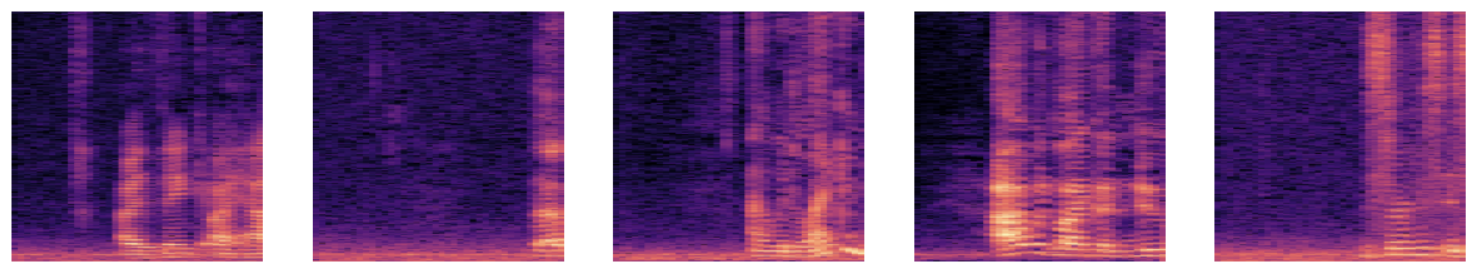

***Organizing Spectrograms into Train, Validation, and Test Folders***


To facilitate effective model training and evaluation, we organized the main folder of spectrograms into three designated folders: train, validation, and test. This structured approach ensures that the dataset is well-organized and accessible for different stages of the machine learning process. The training folder is used to train the model, while the validation folder allows for hyperparameter tuning and model selection. The test folder serves as an independent dataset for evaluating the final model's performance. By systematically dividing the spectrograms into these categories, we enhance the clarity and manageability of the dataset, which is essential for achieving accurate and reliable results in the emotion classification task.

In [ ]:
import os
import shutil
import pandas as pd

# Paths
csv_file_path = '/content/drive/MyDrive/emotional_speech/recordings_csv_with_size.csv'
spectrograms_folder = '/content/drive/MyDrive/emotional_speech/output_final_specto/all_outputs'
output_base_folder = '/content/drive/MyDrive/emotional_speech/output_final_specto/all_outputs_split_to'
train_folder = os.path.join(output_base_folder, 'train')
test_folder = os.path.join(output_base_folder, 'test')
validation_folder = os.path.join(output_base_folder, 'validation')

# Create output directories if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)

# Load the CSV
recordings_df = pd.read_csv(csv_file_path)

# Map 'type' to respective folders
type_to_folder = {
    'train': train_folder,
    'test': test_folder,
    'validation': validation_folder
}

# Iterate over each row in the CSV
for _, row in recordings_df.iterrows():
    # Construct the spectrogram file name
    wav_file_name = row['name_of_file']
    spectrogram_file_name = wav_file_name.replace('.wav', '_spectrogram.png')
    spectrogram_file_path = os.path.join(spectrograms_folder, spectrogram_file_name)

    # Determine the target folder
    target_folder = type_to_folder[row['type']]
    target_file_path = os.path.join(target_folder, spectrogram_file_name)

    # Move the file if it exists
    if os.path.exists(spectrogram_file_path):
        shutil.copy(spectrogram_file_path, target_file_path)
    else:
        print(f"File not found: {spectrogram_file_path}")


***Verifying File Counts in Train, Validation, and Test Folders***

To ensure that our dataset is properly balanced and adheres to the predefined distribution, we implemented a verification process to check the number of files in each of the three designated folders: train, validation, and test. This step involves counting the files in each folder and comparing them against the expected assignments, which typically consist of a specific percentage of the total dataset (e.g., 70% for training, 15% for validation, and 15% for testing). By confirming that the file counts align with these assignments, we can maintain the integrity of the dataset structure, ensuring that the model is trained and evaluated on appropriately distributed data. This verification process is crucial for minimizing biases and optimizing model performance in the emotion classification task.

In [ ]:
from google.colab import drive
import os


def list_folders_and_files(directory):
    folder_counts = {}
    total_files = 0

    # Loop through each item in the directory
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            # Count the number of files in the folder
            num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            folder_counts[folder_name] = num_files
            total_files += num_files

    # Calculate and print percentages (avoid division by zero)
    if total_files > 0:
        for folder, count in folder_counts.items():
            percentage = round(count / total_files * 100, 2)
            # print the counter for each folder:
            print(f"{folder}: {count}, {percentage}%")

        print(f"Total files: {total_files}")
    else:
        print("No files found in the directory.")

# Specify the directory in Google Drive
directory_path = '/content/drive/MyDrive/emotional_speech/output_final_specto/all_outputs_split_to'

# List folders and number of files in each folder
list_folders_and_files(directory_path)




***Data Preparation for Neural Network Training***

After transforming the data into a NumPy array and adding the channel dimension, several crucial steps are undertaken to prepare the data for training a neural network. Normalization ensures all pixel values are in the range [0, 1], which is achieved by dividing by 255. Shuffling the data prevents the model from learning any unintended ordering in the training and validation sets, enhancing the robustness of the training process. One-hot encoding is applied to the labels, converting them into a format suitable for classification tasks using tf.keras.utils.to_categorical.
Additionally, data augmentation can be employed to apply random transformations, such as rotations and translations, to the images. This optional step helps to artificially increase the dataset size and improve the model's ability to generalize to new, unseen data.

***Verification of Data Integrity***

During our initial training run, we observed that the model's accuracy was very low. To ensure the classification process was correct and not corrupted by preprocessing, we conducted a thorough verification of data integrity. This involved meticulously checking that each spectrogram image matched its corresponding label, as derived from the filenames. Ensuring accurate labeling is critical, as any errors in this step can significantly affect the training outcomes and model performance. By confirming the correctness of the labels and the integrity of the data preprocessing pipeline, we aimed to eliminate any potential sources of error that could compromise the effectiveness of our neural network.

In [ ]:
import os
import random
import math
import numpy as np

# Parameters
DATA_PATH = '/content/drive/MyDrive/emotional_speech/output_final_specto/all_outputs_split_to'
IMG_HEIGHT, IMG_WIDTH = 437, 437
CLASSES = ['ANG', 'HAP', 'SAD', 'NEU', 'DIS', 'FEA']

def get_label_from_filename(filename):
    parts = filename.split('_')
    emotion = parts[3]
    return emotion

def load_data_filenames(data_path, classes):
    filenames, labels = [], []
    for file in os.listdir(data_path):
        file_path = os.path.join(data_path, file)
        if file_path.endswith('.png'):
            label = get_label_from_filename(file)
            if label in classes:
                filenames.append(file)
                labels.append(label)
    return filenames, labels

# Load all data filenames
train_data_path = os.path.join(DATA_PATH, 'train')
validation_data_path = os.path.join(DATA_PATH, 'validation')
test_data_path = os.path.join(DATA_PATH, 'test')

train_filenames, train_labels = load_data_filenames(train_data_path, CLASSES)
validation_filenames, validation_labels = load_data_filenames(validation_data_path, CLASSES)
test_filenames, test_labels = load_data_filenames(test_data_path, CLASSES)

# Combine all filenames and labels for sampling
all_filenames = train_filenames + validation_filenames + test_filenames
all_labels = train_labels + validation_labels + test_labels

# Determine sample size for 95% confidence level
population_size = len(all_filenames)
confidence_level = 0.95
margin_of_error = 0.05

z_score = 1.96  # Z-score for 95% confidence
p = 0.5  # Proportion of the population (worst case)

# Sample size calculation using the formula
sample_size = math.ceil((z_score**2 * p * (1 - p)) / (margin_of_error**2) / (1 + (z_score**2 * p * (1 - p)) / (margin_of_error**2 * population_size)))
print(f"Sample size for 95% confidence: {sample_size}")

# Randomly select the sample
random_indices = random.sample(range(population_size), sample_size)

# Print the filenames and labels of the selected sample
for idx in random_indices:
    print(f"Filename: {all_filenames[idx]}, Label: {all_labels[idx]}")


In [ ]:
!pip install tensorflow

***Model Training - defining the model***

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import cv2

# Parameters
DATA_PATH = '/content/drive/MyDrive/emotional_speech/output_final_specto/all_outputs_split_to'  # Update with the correct path
IMG_HEIGHT, IMG_WIDTH = 437, 437  # Dimensions for spectrograms (adjust if needed)
CLASSES = ['ANG', 'HAP', 'SAD', 'NEU', 'DIS', 'FEA']  # List all your emotion classes
NUM_CLASSES = len(CLASSES)

# Function to extract label from filename
def get_label_from_filename(filename):
    parts = filename.split('_')
    emotion = parts[3]  # The emotion label
    return emotion

# Function to load dataset
def load_data(data_path, classes):
    data, labels = [], []
    for file in os.listdir(data_path):
        file_path = os.path.join(data_path, file)
        if file_path.endswith('.png'):  # Assuming spectrograms are in PNG format
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
            img = img / 255.0  # Normalize the image

            label = get_label_from_filename(file)
            if label in classes:
                data.append(img)
                labels.append(classes.index(label))

    data = np.array(data)
    data = data[..., np.newaxis]  # Adding channel dimension
    labels = np.array(labels)
    return data, labels

# Load train, validation, and test datasets
train_data_path = os.path.join(DATA_PATH, 'train')
validation_data_path = os.path.join(DATA_PATH, 'validation')
test_data_path = os.path.join(DATA_PATH, 'test')

train_data, train_labels = load_data(train_data_path, CLASSES)
validation_data, validation_labels = load_data(validation_data_path, CLASSES)
test_data, test_labels = load_data(test_data_path, CLASSES)

# Shuffle the train and validation data
train_data, train_labels = shuffle(train_data, train_labels, random_state=42)
validation_data, validation_labels = shuffle(validation_data, validation_labels, random_state=42)

# Convert labels to categorical
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=NUM_CLASSES)
validation_labels = tf.keras.utils.to_categorical(validation_labels, num_classes=NUM_CLASSES)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=NUM_CLASSES)

# Print the shape of the data for verification
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation data shape: {validation_data.shape}, Validation labels shape: {validation_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_labels.shape}")

# Define the model
model = tf.keras.models.Sequential()

# Convolutional layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# Fully connected layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Adjust learning rate if necessary
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # Adjust rotation range
    width_shift_range=0.1,  # Adjust width shift range
    height_shift_range=0.1,  # Adjust height shift range
    horizontal_flip=True
)

datagen.fit(train_data)

# Fit the model using the data generator
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    datagen.flow(train_data, train_labels, batch_size=32),
    epochs=50,  # Increase epochs if needed
    validation_data=(validation_data, validation_labels),
    callbacks=[early_stopping]
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the model
model.save('/path/to/save/model.h5')  # Replace with your desired path


***Improving Model Performance: A Path Forward***

The current model shows consistently low performance across training, validation, and test datasets, indicating suboptimal architecture and training procedures. The training accuracy fluctuates around 0.18-0.19, while the validation and test accuracies remain similarly low, suggesting poor learning and generalization. Additionally, the high and unstable losses point to issues such as overfitting. Moving forward, we will improve these results by implementing techniques from several articles we believe will help. These include enhanced data preprocessing and augmentation, experimenting with deeper and more complex model architectures, applying regularization methods, adjusting learning rates and batch sizes, utilizing early stopping, conducting thorough hyperparameter tuning, and employing robust validation strategies such as k-fold cross-validation.